[*********************100%%**********************]  1 of 1 completed
c:\Users\Wolfrank\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



Moving Averages of Delta:
Yearly Average: -0.09%
10-day MA (latest): -0.25%
20-day MA (latest): -0.03%
50-day MA (latest): 0.03%
200-day MA (latest): 0.04%

Backtest Results:
Total Trades: 206
Total Profit: -30963.95 points
Win Rate: 0.0%
Average Profit per Trade: -150.31 points


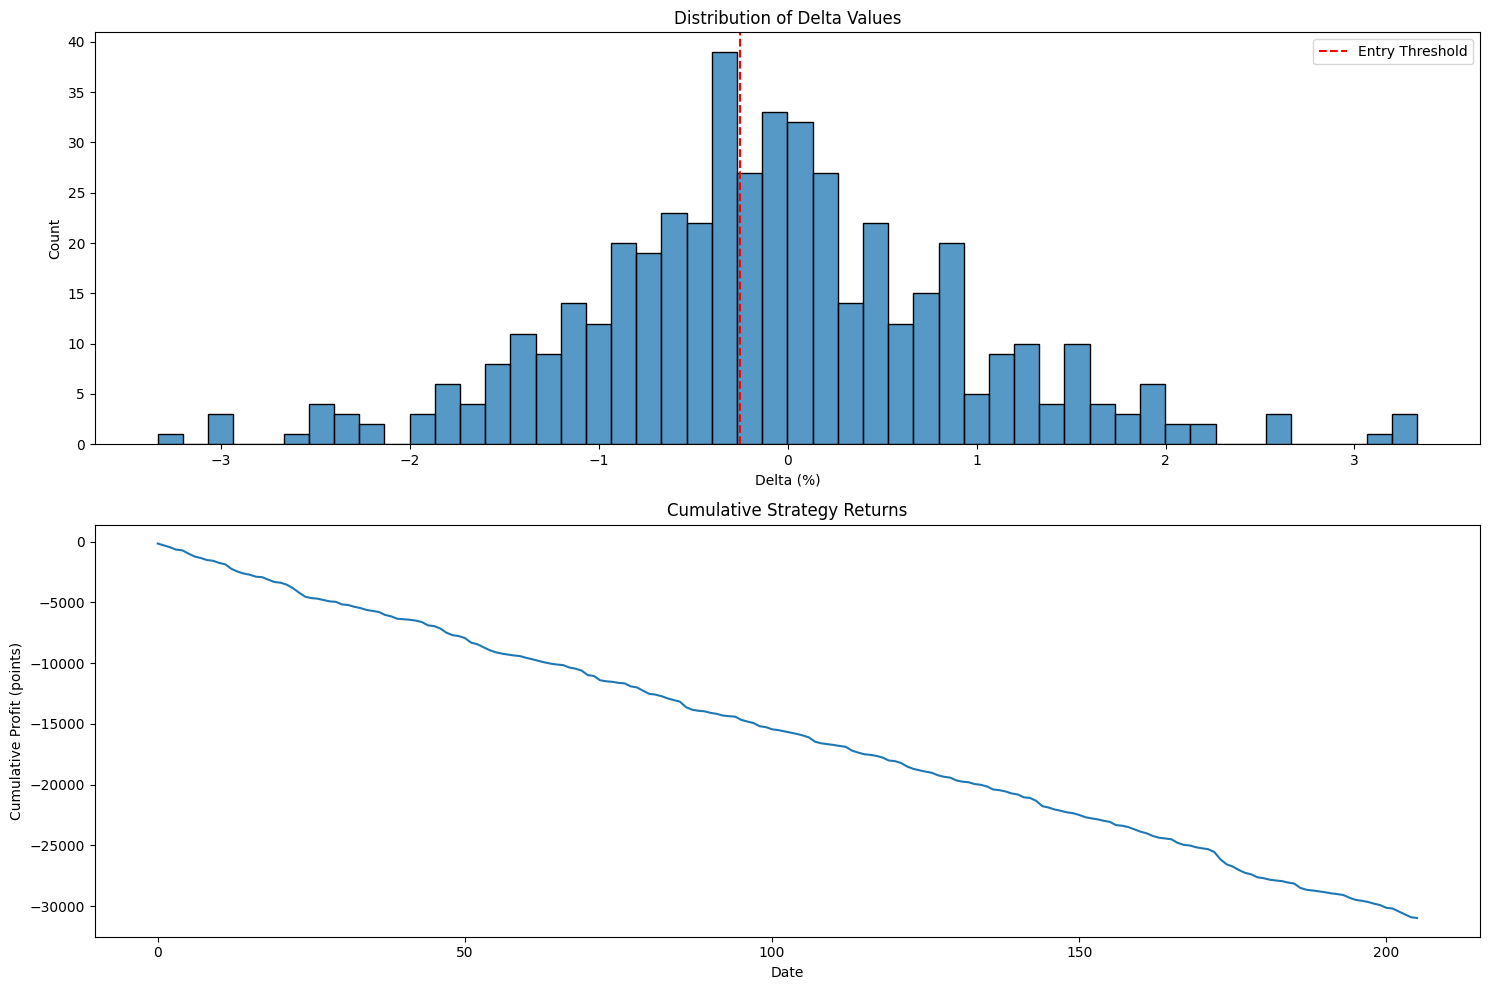

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz

def get_market_data():
    # Download MNQ futures data
    mnq = yf.download("MNQ=F", start="2023-01-01", end="2024-11-15", interval="1h")
    return mnq

def prepare_data(df):
    # Convert index to US/Eastern timezone
    df.index = df.index.tz_convert('US/Eastern')
    
    # Create daily dataframe with specific times we need
    daily_data = pd.DataFrame()
    
    # Previous day's close (4:00 PM ET)
    daily_data['prev_close'] = df['Close'].between_time('15:45', '16:00').resample('D').last()
    
    # Current day's open (8:45 AM ET)
    daily_data['open_845'] = df['Open'].between_time('08:45', '09:00').resample('D').first()
    
    # Current day's close (3:45 PM ET)
    daily_data['close_345'] = df['Close'].between_time('15:45', '16:00').resample('D').first()
    
    # Calculate DELTA
    daily_data['delta'] = ((daily_data['open_845'] - daily_data['prev_close']) / daily_data['prev_close']) * 100
    
    # Remove rows with NaN values
    daily_data = daily_data.dropna()
    
    return daily_data

def calculate_moving_averages(data):
    ma_periods = [10, 20, 50, 200]
    stats = {}
    
    for period in ma_periods:
        stats[f'delta_ma_{period}'] = data['delta'].rolling(window=period).mean()
    
    # Calculate yearly average
    stats['delta_yearly'] = data['delta'].mean()
    
    return stats

def backtest_strategy(data):
    # Initialize results
    trades = []
    
    for idx, row in data.iterrows():
        # Trading logic: If delta < -0.25% (25% lower than previous close)
        if row['delta'] < -0.25:
            entry_price = row['open_845']
            exit_price = row['close_345']
            profit = entry_price - exit_price  # Short position
            trades.append({
                'date': idx,
                'entry': entry_price,
                'exit': exit_price,
                'profit': profit,
                'delta': row['delta']
            })
    
    return pd.DataFrame(trades)

def plot_results(data, trades, stats):
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Delta distribution
    sns.histplot(data=data, x='delta', bins=50, ax=ax1)
    ax1.axvline(x=-0.25, color='r', linestyle='--', label='Entry Threshold')
    ax1.set_title('Distribution of Delta Values')
    ax1.set_xlabel('Delta (%)')
    ax1.legend()
    
    # Plot 2: Cumulative returns
    if not trades.empty:
        trades['cumulative_profit'] = trades['profit'].cumsum()
        trades['cumulative_profit'].plot(ax=ax2)
        ax2.set_title('Cumulative Strategy Returns')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Cumulative Profit (points)')
    
    plt.tight_layout()
    return fig

def main():
    # Get and prepare data
    raw_data = get_market_data()
    daily_data = prepare_data(raw_data)
    
    # Calculate statistics
    stats = calculate_moving_averages(daily_data)
    
    # Run backtest
    trades_df = backtest_strategy(daily_data)
    
    # Print results
    print("\nMoving Averages of Delta:")
    print(f"Yearly Average: {stats['delta_yearly']:.2f}%")
    for period in [10, 20, 50, 200]:
        print(f"{period}-day MA (latest): {stats[f'delta_ma_{period}'].iloc[-1]:.2f}%")
    
    if not trades_df.empty:
        print("\nBacktest Results:")
        print(f"Total Trades: {len(trades_df)}")
        print(f"Total Profit: {trades_df['profit'].sum():.2f} points")
        print(f"Win Rate: {(trades_df['profit'] > 0).mean()*100:.1f}%")
        print(f"Average Profit per Trade: {trades_df['profit'].mean():.2f} points")
    else:
        print("\nNo trades were executed based on the strategy criteria.")
    
    # Plot results
    plot_results(daily_data, trades_df, stats)
    plt.show()

if __name__ == "__main__":
    main()